In [1]:
import Nets
using CoordinateTransformations
using ForwardDiff
using MLDataPattern
using Plots; pyplot()
using ProgressMeter
using Interact

INFO: Recompiling stale cache file /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Nets.ji for module Nets.


In [51]:
reload("Nets")

INFO: Recompiling stale cache file /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Nets.ji for module Nets.


In [52]:
f(x) = .-abs.(x)

X = [[x] for x in linspace(-pi, pi, 60)]
Y = [hcat(f(x), ForwardDiff.jacobian(f, x)) for x in X];

test_data = collect(zip(X, Y))
# train_data, test_data = splitobs(shuffleobs(data), 1/6);
train_data = [([x], hcat(f([x]),  ForwardDiff.jacobian(f, [x]))) for x in [-0.5, 0.5]]

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
for (x, yJ) in train_data
    y = yJ[:, 1]
    J = yJ[:, 2:end]
    @assert y ≈ f(x)
    @assert J ≈ ForwardDiff.jacobian(f, x)
end

u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

for (u, vJ) in train_data_scaled
    v = vJ[:, 1]
    J = vJ[:, 2:end]
    @assert isapprox(v |> v_to_y, u |> u_to_x |> f, atol=1e-6)
    @assert J ≈ ForwardDiff.jacobian(u -> u |> u_to_x |> f |> y_to_v, u)
    @assert maximum(abs, J) <= 1.0 + 1e-5
    
end

In [53]:
widths = [1, 4, 1]

function sensitive_loss(λ)
    q = [1.0-λ λ]
    (params, x, y) -> begin
            sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
    end
end

sensitive_loss (generic function with 1 method)

In [60]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 1000;

mean((xy->begin  # In[61], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 3.7380247014997554


Progress:  91%|█████████████████████████████████████    |  ETA: 0:00:00

mean((xy->begin  # In[61], line 15:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 1.3761467210846121


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01



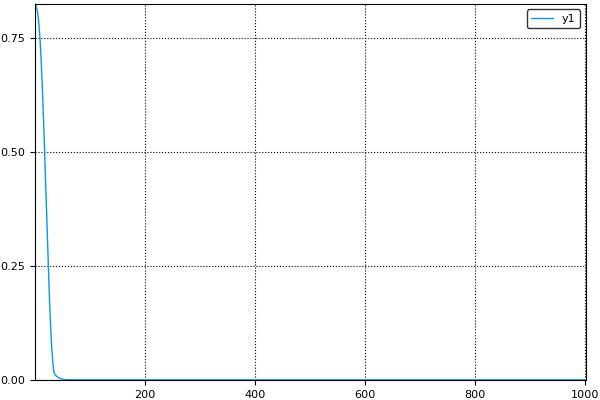

In [61]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.9)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=1))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, maximum(losses)))




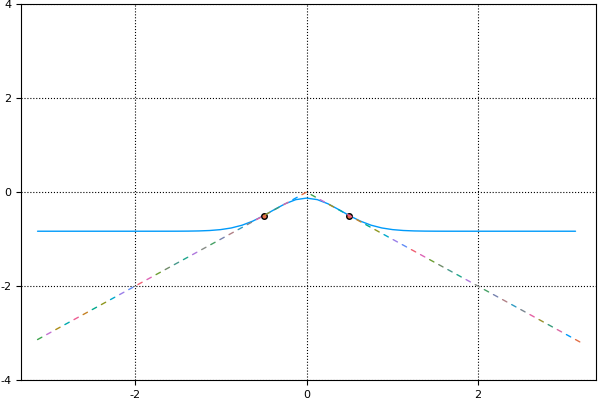

In [62]:
plt = plot(linspace(-pi, pi, 51), x -> net([x])[1], legend=nothing, ylim=(-4, 4))
plot!(plt, [x[1] for (x, y) in train_data], [y[1] for (x, y) in train_data], line=nothing, marker=:circle)
for (x, y) in zip(X, Y)
    eps = 5e-2
    plot!(plt, [x[1], x[1] + eps], [y[1], y[1] + eps * y[2]])
end
plt

In [39]:
@manipulate for i1 in linspace(-10, 10, 51), 
    i2 in linspace(-10, 10, 51), 
    i3 in linspace(-10, 10, 51), 
    i4 in linspace(-10, 10, 51),
    i5 in linspace(-10, 10, 51),
    i6 in linspace(-10, 10, 51),
    i7 in linspace(-10, 10, 51)
    n = Nets.Net(Nets.Params(widths, params .+ [i1, i2, i3, i4, i5, i6, i7]), x_to_u, v_to_y)
    plt = plot(linspace(-pi, pi, 51), x -> n([x])[1], legend=nothing, ylim=(-4, 4))
    plot!(plt, [x[1] for (x, y) in train_data], [y[1] for (x, y) in train_data], line=nothing, marker=:circle)
    plt
end

Interact.Options{:SelectionSlider,Float64}(17: "input-8" = 0.0 Float64 , "i1", 0.0, "0.0", Interact.OptionDict(DataStructures.OrderedDict("-10.0"=>-10.0,"-9.6"=>-9.6,"-9.2"=>-9.2,"-8.8"=>-8.8,"-8.4"=>-8.4,"-8.0"=>-8.0,"-7.6"=>-7.6,"-7.2"=>-7.2,"-6.8"=>-6.8,"-6.4"=>-6.4…), Dict(1.2=>"1.2",9.6=>"9.6",2.0=>"2.0",8.0=>"8.0",-0.8=>"-0.8",-3.6=>"-3.6",5.6=>"5.6",-8.8=>"-8.8",-6.4=>"-6.4",-6.8=>"-6.8"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(19: "input-9" = 0.0 Float64 , "i2", 0.0, "0.0", Interact.OptionDict(DataStructures.OrderedDict("-10.0"=>-10.0,"-9.6"=>-9.6,"-9.2"=>-9.2,"-8.8"=>-8.8,"-8.4"=>-8.4,"-8.0"=>-8.0,"-7.6"=>-7.6,"-7.2"=>-7.2,"-6.8"=>-6.8,"-6.4"=>-6.4…), Dict(1.2=>"1.2",9.6=>"9.6",2.0=>"2.0",8.0=>"8.0",-0.8=>"-0.8",-3.6=>"-3.6",5.6=>"5.6",-8.8=>"-8.8",-6.4=>"-6.4",-6.8=>"-6.8"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(21: "input-10" = 0.0 Float64 , "i3", 0.0, "0.0", Interact.OptionDict(DataStructures.OrderedDict("-10.0"=>-10.0,"-9.6"=>-9.6,"-9.2"=>-9.2,"-8.8"=>-8.8,"-8.4"=>-8.4,"-8.0"=>-8.0,"-7.6"=>-7.6,"-7.2"=>-7.2,"-6.8"=>-6.8,"-6.4"=>-6.4…), Dict(1.2=>"1.2",9.6=>"9.6",2.0=>"2.0",8.0=>"8.0",-0.8=>"-0.8",-3.6=>"-3.6",5.6=>"5.6",-8.8=>"-8.8",-6.4=>"-6.4",-6.8=>"-6.8"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(23: "input-11" = 0.0 Float64 , "i4", 0.0, "0.0", Interact.OptionDict(DataStructures.OrderedDict("-10.0"=>-10.0,"-9.6"=>-9.6,"-9.2"=>-9.2,"-8.8"=>-8.8,"-8.4"=>-8.4,"-8.0"=>-8.0,"-7.6"=>-7.6,"-7.2"=>-7.2,"-6.8"=>-6.8,"-6.4"=>-6.4…), Dict(1.2=>"1.2",9.6=>"9.6",2.0=>"2.0",8.0=>"8.0",-0.8=>"-0.8",-3.6=>"-3.6",5.6=>"5.6",-8.8=>"-8.8",-6.4=>"-6.4",-6.8=>"-6.8"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(25: "input-12" = 0.0 Float64 , "i5", 0.0, "0.0", Interact.OptionDict(DataStructures.OrderedDict("-10.0"=>-10.0,"-9.6"=>-9.6,"-9.2"=>-9.2,"-8.8"=>-8.8,"-8.4"=>-8.4,"-8.0"=>-8.0,"-7.6"=>-7.6,"-7.2"=>-7.2,"-6.8"=>-6.8,"-6.4"=>-6.4…), Dict(1.2=>"1.2",9.6=>"9.6",2.0=>"2.0",8.0=>"8.0",-0.8=>"-0.8",-3.6=>"-3.6",5.6=>"5.6",-8.8=>"-8.8",-6.4=>"-6.4",-6.8=>"-6.8"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(27: "input-13" = 0.0 Float64 , "i6", 0.0, "0.0", Interact.OptionDict(DataStructures.OrderedDict("-10.0"=>-10.0,"-9.6"=>-9.6,"-9.2"=>-9.2,"-8.8"=>-8.8,"-8.4"=>-8.4,"-8.0"=>-8.0,"-7.6"=>-7.6,"-7.2"=>-7.2,"-6.8"=>-6.8,"-6.4"=>-6.4…), Dict(1.2=>"1.2",9.6=>"9.6",2.0=>"2.0",8.0=>"8.0",-0.8=>"-0.8",-3.6=>"-3.6",5.6=>"5.6",-8.8=>"-8.8",-6.4=>"-6.4",-6.8=>"-6.8"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(29: "input-14" = 0.0 Float64 , "i7", 0.0, "0.0", Interact.OptionDict(DataStructures.OrderedDict("-10.0"=>-10.0,"-9.6"=>-9.6,"-9.2"=>-9.2,"-8.8"=>-8.8,"-8.4"=>-8.4,"-8.0"=>-8.0,"-7.6"=>-7.6,"-7.2"=>-7.2,"-6.8"=>-6.8,"-6.4"=>-6.4…), Dict(1.2=>"1.2",9.6=>"9.6",2.0=>"2.0",8.0=>"8.0",-0.8=>"-0.8",-3.6=>"-3.6",5.6=>"5.6",-8.8=>"-8.8",-6.4=>"-6.4",-6.8=>"-6.8"…)), Any[], Any[], true, "horizontal")

LoadError: [91mDimensionMismatch("arrays could not be broadcast to a common size")[39m

In [9]:
net.params.weights

2-element Array{Base.ReshapedArray{Float64,2,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true},Tuple{}},1}:
 [-0.781163; 0.852994]
 [-0.769834 -0.696507]

In [10]:
params

7-element Array{Float64,1}:
 -0.781163   
  0.852994   
 -0.769834   
 -0.696507   
  0.00021235 
  0.000117051
 -0.00285645 

In [77]:
f(x) = [sin(2 * x[1])]

X = [[x] for x in linspace(-pi, pi, 60)]
Y = [hcat(f(x), ForwardDiff.jacobian(f, x)) for x in X];

data = collect(zip(X, Y))
train_data, test_data = splitobs(shuffleobs(data), 1/10);

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
for (x, yJ) in train_data
    y = yJ[:, 1]
    J = yJ[:, 2:end]
    @assert y ≈ f(x)
    @assert J ≈ ForwardDiff.jacobian(f, x)
end

u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

for (u, vJ) in train_data_scaled
    v = vJ[:, 1]
    J = vJ[:, 2:end]
    @assert isapprox(v |> v_to_y, u |> u_to_x |> f, atol=1e-6)
    @assert J ≈ ForwardDiff.jacobian(u -> u |> u_to_x |> f |> y_to_v, u)
    @assert maximum(abs, J) <= 1.0 + 1e-5
    
end

In [78]:
widths = [1, 16, 16, 16, 1]

function sensitive_loss(λ)
    q = [1.0-λ λ]
    (params, x, y) -> begin
            sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
    end
end

sensitive_loss (generic function with 1 method)

In [79]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 500;

mean((xy->begin  # In[84], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.5167945962843192


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


mean((xy->begin  # In[84], line 15:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.7031449982530235



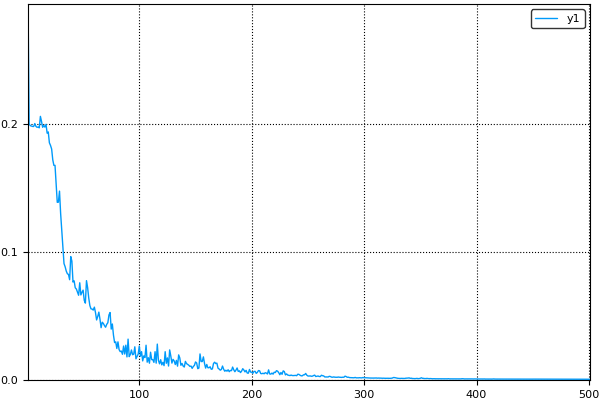

In [84]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.5)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=2))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))


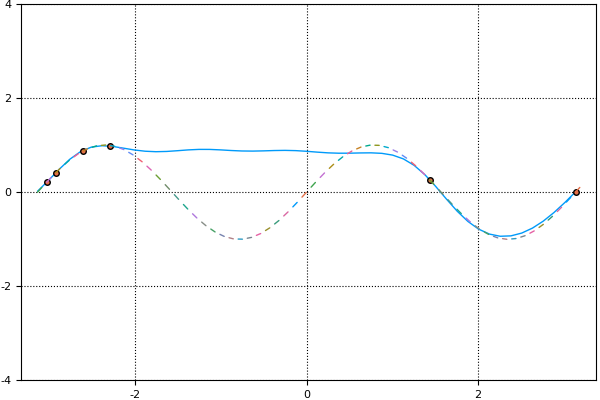

In [85]:
plt = plot(linspace(-pi, pi, 51), x -> net([x])[1], legend=nothing, ylim=(-4, 4))
plot!(plt, [x[1] for (x, y) in train_data], [y[1] for (x, y) in train_data], line=nothing, marker=:circle)
for (x, y) in zip(X, Y)
    eps = 5e-2
    plot!(plt, [x[1], x[1] + eps], [y[1], y[1] + eps * y[2]])
end
plt